# FASTER R-CNN

## Importing libraries

In [0]:
# !wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xf VOCtrainval_06-Nov-2007.tar
# !pip install git+https://github.com/pytorch/vision.git@layers

# !wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xf VOCtrainval_06-Nov-2007.tar
!pip install git+https://github.com/pytorch/vision.git@layers

  Cloning https://github.com/pytorch/vision.git (to revision layers) to /tmp/pip-req-build-zkb82n3c
  Running command git clone -q https://github.com/pytorch/vision.git /tmp/pip-req-build-zkb82n3c
  Running command git checkout -b layers --track origin/layers
  Switched to a new branch 'layers'
  Branch 'layers' set up to track remote branch 'layers' from 'origin'.
  Created wheel for torchvision: filename=torchvision-0.2.0-cp36-cp36m-linux_x86_64.whl size=3855325 sha256=070f0cb67ce3084aaa41150d82d47b3aed353ef685b69ee6813b5d1998ed1b7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-rg7iuq9d/wheels/92/0b/44/94c4a30adbc2cb951a89e225a51e11173b28da1f23bc920856
Successfully built torchvision
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches,patheffects
import torch
from torchvision import layers
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset , RandomSampler
import torchvision.transforms.functional as FT
from torch.autograd import Variable
from PIL import Image
import xml.etree.ElementTree as ET

from collections import defaultdict
import itertools
from pathlib import Path
import json
import os
import random
from tqdm import tqdm,trange
import time
from math import sqrt
from collections import namedtuple
from string import Template
from torch.autograd import Function
import time

import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"{torch.__version__} and {device}")

1.4.0 and cuda


In [0]:
dataPath=Path("VOCdevkit/VOC2007/")

## Transformation

### Horizontal flip

In [0]:
### The bounding box format is y_min , x_min , y_max , x_max
def flip(image, boxes):
    """
    Flip image horizontally.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)
    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 1] = image.width - boxes[:, 1] - 1
    new_boxes[:, 3] = image.width - boxes[:, 3] - 1
    new_boxes = new_boxes[:, [0, 3, 2, 1]]

    return new_image, new_boxes

### Resize

In [0]:
def resize(image, boxes=None, dims=(600, 1000), return_percent_coords=False):
  """
  Resize image. For the Faster rcnn, resize to (1000, 600).

  Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
  you may choose to retain them.

  :param image: image, a PIL Image
  :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
  :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
  """
  # Resize image
  new_image = FT.resize(image, dims)

  if boxes is None:
    return new_image
  # Resize bounding boxes
  old_dims = torch.FloatTensor([ image.height , image.width,image.height , image.width]).unsqueeze(0)
  new_boxes = boxes / old_dims  # percent coordinates

  if not return_percent_coords:
      new_dims = torch.FloatTensor([dims[0], dims[1], dims[0], dims[1]]).unsqueeze(0)
      new_boxes = new_boxes * new_dims

  return new_image, new_boxes


### Photometric Distortion

In [0]:
def photometric_distort(image):
  """
  Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.

  :param image: image, a PIL Image
  :return: distorted image
  """
  new_image = image

  distortions = [FT.adjust_brightness,
                 FT.adjust_contrast,
                 FT.adjust_saturation,
                 FT.adjust_hue]

  random.shuffle(distortions)

  for d in distortions:
      if random.random() < 0.5:
          if d.__name__ is 'adjust_hue':
              # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
              adjust_factor = random.uniform(-18 / 255., 18 / 255.)
          else:
              # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
              adjust_factor = random.uniform(0.5, 1.5)

          # Apply this distortion
          new_image = d(new_image, adjust_factor)

  return new_image

## Dataset

In [0]:
class VOCDataset(Dataset):
  class_names = ('__background__',
                 'aeroplane', 'bicycle', 'bird', 'boat',
                 'bottle', 'bus', 'car', 'cat', 'chair',
                 'cow', 'diningtable', 'dog', 'horse',
                 'motorbike', 'person', 'pottedplant',
                 'sheep', 'sofa', 'train', 'tvmonitor')

  def __init__(self, data_dir, split):
      """Dataset for VOC data.
      Args:
          data_dir: the root of the VOC2007 or VOC2012 dataset, the directory contains the following sub-directories:
              Annotations, ImageSets, JPEGImages, SegmentationClass, SegmentationObject.
      """
      self.data_dir = data_dir
      self.split = split
      image_sets_file = self.data_dir/f"ImageSets/Main/{self.split}.txt"
      self.ids = VOCDataset._read_image_ids(image_sets_file)

      self.class_dict = {class_name: i for i, class_name in enumerate(self.class_names)}

      # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
      # see: https://pytorch.org/docs/stable/torchvision/models.html
      self.mean = torch.tensor([0.485, 0.456, 0.406])
      self.std = torch.tensor([0.229, 0.224, 0.225])

  def __getitem__(self, index):
      image_id = self.ids[index]
      boxes, labels = self._get_annotation(image_id)
      image = self._read_image(image_id)
      image, boxes, labels = self.transform(image, boxes, labels , self.split)
      return image, boxes, labels

  def get_image(self, index):
      image_id = self.ids[index]
      image = self._read_image(image_id)
      return image

  def get_annotation(self, index):
      image_id = self.ids[index]
      return self._get_annotation(image_id)

  def __len__(self):
      return len(self.ids)

  @staticmethod
  def _read_image_ids(image_sets_file):
      ids = []
      with open(image_sets_file) as f:
          for line in f:
              ids.append(line.rstrip())
      return ids

  def _get_annotation(self, image_id):
      annotation_file = self.data_dir/f"Annotations/{image_id}.xml"
      objects = ET.parse(annotation_file).findall("object")
      boxes = []
      labels = []
      for obj in objects:
          class_name = obj.find('name').text.lower().strip()
          bbox = obj.find('bndbox')
          # VOC dataset format follows Matlab, in which indexes start from 0
          x1 = float(bbox.find('xmin').text) - 1
          y1 = float(bbox.find('ymin').text) - 1
          x2 = float(bbox.find('xmax').text) - 1
          y2 = float(bbox.find('ymax').text) - 1
          boxes.append([ y1 , x1, y2, x2])
          labels.append(self.class_dict[class_name])

      return (np.array(boxes, dtype=np.float32),
              np.array(labels, dtype=np.int64))

  def _read_image(self, image_id):
      image_file = self.data_dir/f"JPEGImages/{image_id}.jpg"
      image = Image.open(image_file).convert("RGB")
      return image

  def transform(self , image, boxes, labels , split):
    """
    Apply the transformations above.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: transformed image, transformed bounding box coordinates, transformed labels
    """
    assert split in {'train', 'test' , "val"}


    new_image = image
    new_boxes = torch.from_numpy(boxes)
    new_labels = torch.from_numpy(labels)
    # Skip the following operations if validation/evaluation
    if split == 'train':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (600, 1000) - this also converts point coordinates to fractional form
    new_image, new_boxes = resize(new_image, new_boxes)

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=self.mean.numpy(), std=self.std.numpy())

    return new_image, new_boxes, new_labels

  def denormalize(self , image):
    image = image.clone().detach().to("cpu")
    if len(image.shape)==4 : image = image.squeeze(0)
    image = image.permute(1,2,0) 
    image = image.mul_(self.std).add_(self.mean) #denormalize
    image = torch.clamp(image,0,1)
    return image.numpy()

In [0]:
trainset  = VOCDataset(dataPath,split="train")
valset = VOCDataset(dataPath,split="val")
print(len(trainset),len(valset))

2501 2510


In [0]:
trainset.class_dict

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

## Visualization

In [0]:
def show_img(im, ax=None):
    ax.imshow(im)
    ax.grid()
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='red'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 3)

def draw_anchors(dataset , index,anchors):
  fig ,ax =plt.subplots(1,1,figsize=(15,10))
  image , boxes , labels = dataset[index]
  image=dataset.denormalize(image)
  ax = show_img(image,ax)
  for i , box in enumerate(anchors):
    box = torch.tensor([box[1],box[0],box[3],box[2]])
    draw_rect(ax , box)
    draw_text(ax , box[:2] ,str(i) , sz=16)

def draw_im(dataset , index):
    f, (ax, ax1) = plt.subplots(1, 2,figsize=(15,10))   
    ax.set_title("Augmented")
    ax1.set_title("original")

    image , boxes , labels = dataset[index]
    image=dataset.denormalize(image)
    ax = show_img(image,ax)
    for box ,label in zip(boxes , labels):
        print(box)
        box = torch.tensor([box[1],box[0],box[3],box[2]])
        draw_rect(ax,box )
        draw_text(ax, box[:2], dataset.class_names[label], sz=16)
    
    original = dataset.get_image(index)
    boxes , labels = dataset.get_annotation(index)
    ax1 = show_img(original,ax1)
    for box ,label in zip(boxes , labels):
      box = torch.tensor([box[1],box[0],box[3],box[2]])
      draw_rect(ax1,box )
      draw_text(ax1, box[:2], dataset.class_names[label], sz=16)

tensor([361.6000, 610.0000, 476.8000, 758.0000])
tensor([227.2000, 390.0000, 588.8000, 616.0000])
tensor([244.8000, 262.0000, 555.2000, 772.0000])
tensor([ 76.8000, 108.0000, 590.4000, 416.0000])


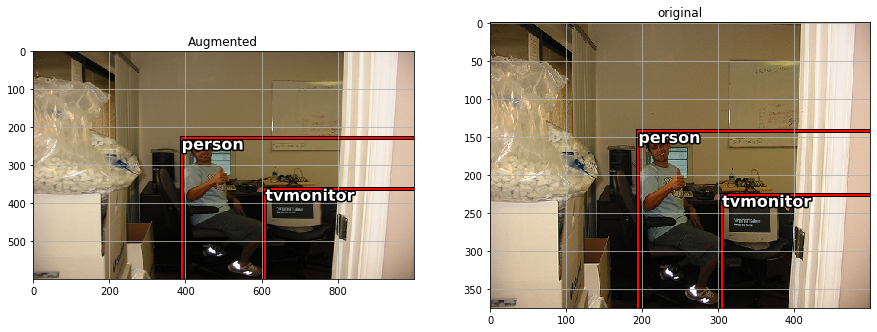

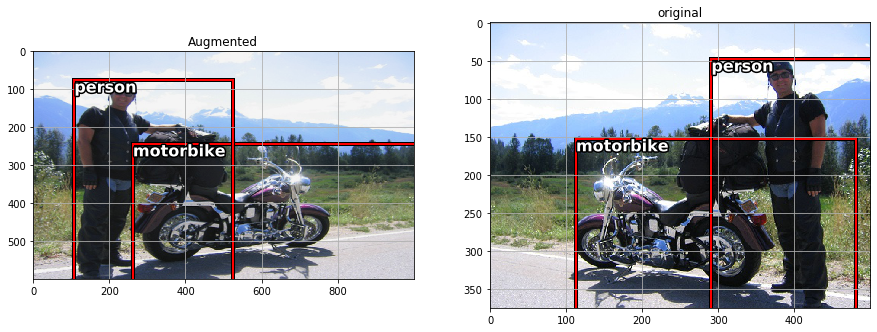

In [0]:
draw_im(trainset,36)
draw_im(trainset,38)

## Utility Function

### No grad Func and other Func




### Cordinate conversion

In [0]:
def nograd(f):
    def new_f(*args,**kwargs):
        with torch.no_grad():
           return f(*args,**kwargs)
    return new_f
  
"""
tools to convert specified type
"""
def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()


def totensor(data, cuda=True):
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    if isinstance(data, torch.Tensor):
        tensor = data.clone().detach()
    if cuda:
        tensor = tensor.to(device)
    return tensor


def scalar(data):
    if isinstance(data, np.ndarray):
        return data.reshape(1)[0]
    if isinstance(data, torch.Tensor):
        return data.item()

In [0]:
def loc2bbox(src_bbox, loc):
    """Decode bounding boxes from bounding box offsets and scales.

    Given bounding box offsets and scales computed by
    :meth:`bbox2loc`, this function decodes the representation to
    coordinates in 2D image coordinates.

    Given scales and offsets :math:`t_y, t_x, t_h, t_w` and a bounding
    box whose center is :math:`(y, x) = p_y, p_x` and size :math:`p_h, p_w`,
    the decoded bounding box's center :math:`\\hat{g}_y`, :math:`\\hat{g}_x`
    and size :math:`\\hat{g}_h`, :math:`\\hat{g}_w` are calculated
    by the following formulas.

    * :math:`\\hat{g}_y = p_h t_y + p_y`
    * :math:`\\hat{g}_x = p_w t_x + p_x`
    * :math:`\\hat{g}_h = p_h \\exp(t_h)`
    * :math:`\\hat{g}_w = p_w \\exp(t_w)`

    The decoding formulas are used in works such as R-CNN [#]_.

    The output is same type as the type of the inputs.

    .. [#] Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. \
    Rich feature hierarchies for accurate object detection and semantic \
    segmentation. CVPR 2014.

    Args:
        src_bbox (array): A coordinates of bounding boxes.
            Its shape is :math:`(R, 4)`. These coordinates are
            :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        loc (array): An array with offsets and scales.
            The shapes of :obj:`src_bbox` and :obj:`loc` should be same.
            This contains values :math:`t_y, t_x, t_h, t_w`.

    Returns:
        array:
        Decoded bounding box coordinates. Its shape is :math:`(R, 4)`. \
        The second axis contains four values \
        :math:`\\hat{g}_{ymin}, \\hat{g}_{xmin},
        \\hat{g}_{ymax}, \\hat{g}_{xmax}`.

    """

    if src_bbox.shape[0] == 0:
        return np.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox


def bbox2loc(src_bbox, dst_bbox):
    """Encodes the source and the destination bounding boxes to "loc".

    Given bounding boxes, this function computes offsets and scales
    to match the source bounding boxes to the target bounding boxes.
    Mathematcially, given a bounding box whose center is
    :math:`(y, x) = p_y, p_x` and
    size :math:`p_h, p_w` and the target bounding box whose center is
    :math:`g_y, g_x` and size :math:`g_h, g_w`, the offsets and scales
    :math:`t_y, t_x, t_h, t_w` can be computed by the following formulas.

    * :math:`t_y = \\frac{(g_y - p_y)} {p_h}`
    * :math:`t_x = \\frac{(g_x - p_x)} {p_w}`
    * :math:`t_h = \\log(\\frac{g_h} {p_h})`
    * :math:`t_w = \\log(\\frac{g_w} {p_w})`

    The output is same type as the type of the inputs.
    The encoding formulas are used in works such as R-CNN [#]_.

    .. [#] Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. \
    Rich feature hierarchies for accurate object detection and semantic \
    segmentation. CVPR 2014.

    Args:
        src_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
            These coordinates are
            :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        dst_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`.
            These coordinates are
            :math:`g_{ymin}, g_{xmin}, g_{ymax}, g_{xmax}`.

    Returns:
        array:
        Bounding box offsets and scales from :obj:`src_bbox` \
        to :obj:`dst_bbox`. \
        This has shape :math:`(R, 4)`.
        The second axis contains four values :math:`t_y, t_x, t_h, t_w`.

    """

    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width

    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width

    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc

### IOU

In [0]:
def bbox_iou(bbox_a, bbox_b):
    """Calculate the Intersection of Unions (IoUs) between bounding boxes.

    IoU is calculated as a ratio of area of the intersection
    and area of the union.

    This function accepts both :obj:`numpy.ndarray` and :obj:`cupy.ndarray` as
    inputs. Please note that both :obj:`bbox_a` and :obj:`bbox_b` need to be
    same type.
    The output is same type as the type of the inputs.

    Args:
        bbox_a (array): An array whose shape is :math:`(N, 4)`.
            :math:`N` is the number of bounding boxes.
            The dtype should be :obj:`numpy.float32`.
        bbox_b (array): An array similar to :obj:`bbox_a`,
            whose shape is :math:`(K, 4)`.
            The dtype should be :obj:`numpy.float32`.

    Returns:
        array:
        An array whose shape is :math:`(N, K)`. \
        An element at index :math:`(n, k)` contains IoUs between \
        :math:`n` th bounding box in :obj:`bbox_a` and :math:`k` th bounding \
        box in :obj:`bbox_b`.

    """
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError

    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

In [0]:
a = np.array([[100,100,200,200]])
b= np.array([[50,150,190,300]])
bbox_iou(a,b)

array([[0.16981132]])

### Anchor Box generation

In [0]:
def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2],
                         anchor_scales=[8, 16, 32]):
    """Generate anchor base windows by enumerating aspect ratio and scales.

    Generate anchors that are scaled and modified to the given aspect ratios.
    Area of a scaled anchor is preserved when modifying to the given aspect
    ratio.

    :obj:`R = len(ratios) * len(anchor_scales)` anchors are generated by this
    function.
    The :obj:`i * len(anchor_scales) + j` th anchor corresponds to an anchor
    generated by :obj:`ratios[i]` and :obj:`anchor_scales[j]`.

    For example, if the scale is :math:`8` and the ratio is :math:`0.25`,
    the width and the height of the base window will be stretched by :math:`8`.
    For modifying the anchor to the given aspect ratio,
    the height is halved and the width is doubled.

    Args:
        base_size (number): The width and the height of the reference window.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.

    Returns:
        ~numpy.ndarray:
        An array of shape :math:`(R, 4)`.
        Each element is a set of coordinates of a bounding box.
        The second axis corresponds to
        :math:`(y_{min}, x_{min}, y_{max}, x_{max})` of a bounding box.

    """
    py = base_size / 2.
    px = base_size / 2.

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4),
                           dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = py - h / 2.
            anchor_base[index, 1] = px - w / 2.
            anchor_base[index, 2] = py + h / 2.
            anchor_base[index, 3] = px + w / 2.
    return anchor_base
generate_anchor_base()

array([[ -37.254833,  -82.50967 ,   53.254833,   98.50967 ],
       [ -82.50967 , -173.01933 ,   98.50967 ,  189.01933 ],
       [-173.01933 , -354.03867 ,  189.01933 ,  370.03867 ],
       [ -56.      ,  -56.      ,   72.      ,   72.      ],
       [-120.      , -120.      ,  136.      ,  136.      ],
       [-248.      , -248.      ,  264.      ,  264.      ],
       [ -82.50967 ,  -37.254833,   98.50967 ,   53.254833],
       [-173.01933 ,  -82.50967 ,  189.01933 ,   98.50967 ],
       [-354.03867 , -173.01933 ,  370.03867 ,  189.01933 ]],
      dtype=float32)

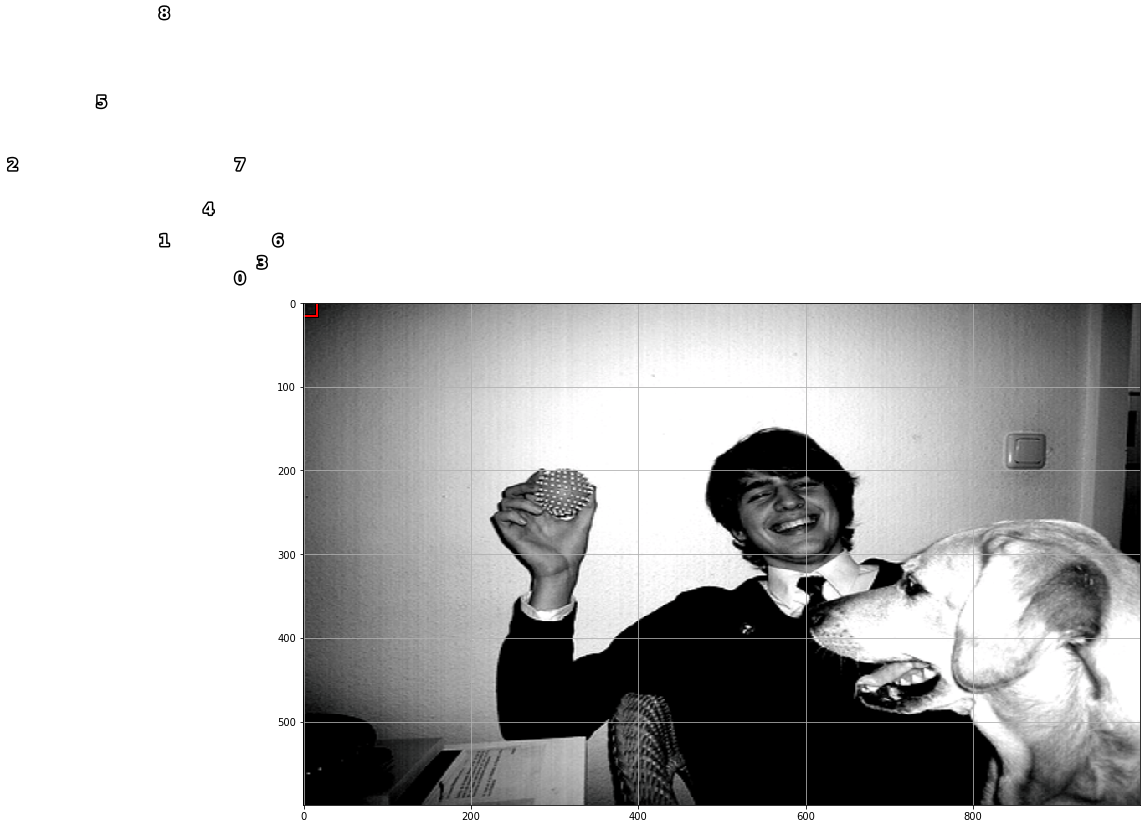

In [0]:
draw_anchors(trainset,64,generate_anchor_base())

### Non Maximum Supression

In [0]:
def non_maximum_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return np.array([])
    # Find the overlap between predicted boxes
    overlap = bbox_iou(boxes, boxes)  
    # Non-Maximum Suppression (NMS)

    # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
    # 1 implies suppress, 0 implies don't suppress
    suppress = np.zeros((boxes.shape[0]), dtype=np.uint8)  # (n_qualified)

    for box in range(boxes.shape[0]):
        # If this box is already marked for suppression
        if suppress[box] == 1:
            continue
        # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
        # Find such boxes and update suppress indices
        suppress = np.maximum(suppress, overlap[box] > overlapThresh)
        # The max operation retains previously suppressed boxes, like an 'OR' operation

        # Don't suppress this box, even though it has an overlap of 1 with itself
        suppress[box] = 0
    suppress = 1-suppress
    return np.where(suppress==1)[0]     


In [0]:
# a = non_maximum_suppression(generate_anchor_base() , 0.1)
# tonumpy(a)
# a=layers.nms(torch.from_numpy(generate_anchor_base()),torch.from_numpy(generate_anchor_base()),0.1)
# tonumpy(a)
# a=a[:,np.newaxis]
# print(a.shape)

In [0]:
# a= layers.nms(torch.from_numpy(generate_anchor_base()),torch.from_numpy(generate_anchor_base()),0.1)
# tonumpy(a)

### Metric

In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Save Model

In [0]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer, loss, best_loss, is_best):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path("./FASTER_RCNN_weights/checkpoint_fasterrcnn.pt")
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path("./FASTER_RCNN_weights/BEST_checkpoint_fasterrcnn.pt"))

## FASTER RCNN MODULES
  1. VGG Extractor
  2. Region Proposal Network
  3. ROI pooling 2D
  4. VGG Classifier
   
  

### VGG BASE

In [0]:
def decom_vgg16():
  vgg = models.vgg16(pretrained=True)
  
  extractor = vgg.features
  classifier = vgg.classifier
#   extractor=torch.nn.Conv2d(3,512,3,16,1)
  # delete final vgg max pool layer
  del extractor[30]
  
  # delete 2 dropout layers and the final layer in classifier
  del classifier[6]
  del classifier[5],classifier[2]
  
  
  # freeze first 4 conv layers
  for layer in extractor[:10]:
    for p in layer.parameters():
      p.requires_grad_(False)
      
  return extractor , classifier

In [0]:
with torch.no_grad():
  extractor ,classifier = decom_vgg16()
  print(extractor(torch.randn(1,3,600,1000)).shape) #testing the size of input after the extractor

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



torch.Size([1, 512, 37, 62])


### Region Proposal Network

#### Generating all shifted anchors
  We genrate anchors for each cell in entire feature map grid  
  For this particular problem total 20646 anchors are generated 
  $$
  37*62*9  = 20646
  $$

In [0]:
def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    # Enumerate all shifted anchors:
    #
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    # return (K*A, 4)

    # !TODO: add support for torch.CudaTensor
    # xp = cuda.get_array_module(anchor_base)
    shift_y = torch.arange(0, height * feat_stride, feat_stride)
    shift_x = torch.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift = np.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + \
             shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor

In [0]:
_enumerate_shifted_anchor(generate_anchor_base() , 16,37,62)

array([[ -37.254833,  -82.50967 ,   53.254833,   98.50967 ],
       [ -82.50967 , -173.01933 ,   98.50967 ,  189.01933 ],
       [-173.01933 , -354.03867 ,  189.01933 ,  370.03867 ],
       ...,
       [ 493.49033 ,  938.7452  ,  674.50964 , 1029.2549  ],
       [ 402.98065 ,  893.49036 ,  765.01935 , 1074.5096  ],
       [ 221.96133 ,  802.98065 ,  946.0387  , 1165.0193  ]],
      dtype=float32)

#### Normal Intilization function

In [0]:
def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

#### Proposal Creator
Proposal Creator takes all the anchor boxes with their predicted loc and score and does a filter operation on predicted boxes using width and height thresholding and afterwards appying pre nms and post nms

In [0]:
class ProposalCreator:
    # unNOTE: I'll make it undifferential
    # unTODO: make sure it's ok
    # It's ok
    """Proposal regions are generated by calling this object.

    The :meth:`__call__` of this object outputs object detection proposals by
    applying estimated bounding box offsets
    to a set of anchors.

    This class takes parameters to control number of bounding boxes to
    pass to NMS and keep after NMS.
    If the paramters are negative, it uses all the bounding boxes supplied
    or keep all the bounding boxes returned by NMS.

    This class is used for Region Proposal Networks introduced in
    Faster R-CNN [#]_.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        nms_thresh (float): Threshold value used when calling NMS.
        n_train_pre_nms (int): Number of top scored bounding boxes
            to keep before passing to NMS in train mode.
        n_train_post_nms (int): Number of top scored bounding boxes
            to keep after passing to NMS in train mode.
        n_test_pre_nms (int): Number of top scored bounding boxes
            to keep before passing to NMS in test mode.
        n_test_post_nms (int): Number of top scored bounding boxes
            to keep after passing to NMS in test mode.
        force_cpu_nms (bool): If this is :obj:`True`,
            always use NMS in CPU mode. If :obj:`False`,
            the NMS mode is selected based on the type of inputs.
        min_size (int): A paramter to determine the threshold on
            discarding bounding boxes based on their sizes.

    """

    def __init__(self,
                 parent_model,
                 nms_thresh=0.7,
                 n_train_pre_nms=12000,
                 n_train_post_nms=2000,
                 n_test_pre_nms=6000,
                 n_test_post_nms=300,
                 min_size=16
                 ):
        self.parent_model = parent_model
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score,
                 anchor, img_size, scale=1.):
        """input should  be ndarray
        Propose RoIs.

        Inputs :obj:`loc, score, anchor` refer to the same anchor when indexed
        by the same index.

        On notations, :math:`R` is the total number of anchors. This is equal
        to product of the height and the width of an image and the number of
        anchor bases per pixel.

        Type of the output is same as the inputs.

        Args:
            loc (array): Predicted offsets and scaling to anchors.
                Its shape is :math:`(R, 4)`.
            score (array): Predicted foreground probability for anchors.
                Its shape is :math:`(R,)`.
            anchor (array): Coordinates of anchors. Its shape is
                :math:`(R, 4)`.
            img_size (tuple of ints): A tuple :obj:`height, width`,
                which contains image size after scaling.
            scale (float): The scaling factor used to scale an image after
                reading it from a file.

        Returns:
            array:
            An array of coordinates of proposal boxes.
            Its shape is :math:`(S, 4)`. :math:`S` is less than
            :obj:`self.n_test_post_nms` in test time and less than
            :obj:`self.n_train_post_nms` in train time. :math:`S` depends on
            the size of the predicted bounding boxes and the number of
            bounding boxes discarded by NMS.

        """
        # NOTE: when test, remember
        # faster_rcnn.eval()
        # to set self.training = False
        if self.parent_model.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        # Convert anchors into proposal via bbox transformations.
        roi = loc2bbox(anchor, loc)

        # Clip predicted boxes to image.
        roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
        roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
        
        
        # Remove predicted boxes with either height or width < threshold.
        min_size = self.min_size * scale
        hs = roi[:, 2] - roi[:, 0]
        ws = roi[:, 3] - roi[:, 1]
        keep = np.where((hs >= min_size) & (ws >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]        

        # Sort all (proposal, score) pairs by score from highest to lowest.
        # Take top pre_nms_topN (e.g. 6000).
        order = score.ravel().argsort()[::-1]
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :] 
        

        # Apply nms (e.g. threshold = 0.7).
        # Take after_nms_topN (e.g. 300).

        # unNOTE: somthing is wrong here!
        # TODO: remove cuda.to_gpu
        # non_max_keep = non_maximum_suppression(roi,self.nms_thresh)
        score=score[np.newaxis,:]
        non_max_keep = layers.nms(torch.from_numpy(roi),torch.from_numpy(score),self.nms_thresh)
        # non_max_keep=non_max_keep[:,np.newaxis]
        if n_post_nms > 0:
            non_max_keep = non_max_keep[:n_post_nms]
        roi = roi[non_max_keep]
        return roi

#### Region Proposal Network

In [0]:


class RegionProposalNetwork(nn.Module):
    """Region Proposal Network introduced in Faster R-CNN.

    This is Region Proposal Network introduced in Faster R-CNN [#]_.
    This takes features extracted from images and propose
    class agnostic bounding boxes around "objects".

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        in_channels (int): The channel size of input.
        mid_channels (int): The channel size of the intermediate tensor.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.
        feat_stride (int): Stride size after extracting features from an
            image.
        initialW (callable): Initial weight value. If :obj:`None` then this
            function uses Gaussian distribution scaled by 0.1 to
            initialize weight.
            May also be a callable that takes an array and edits its values.
        proposal_creator_params (dict): Key valued paramters for
            :class:`model.utils.creator_tools.ProposalCreator`.

    .. seealso::
        :class:`~model.utils.creator_tools.ProposalCreator`

    """

    def __init__(
            self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
            anchor_scales=[8, 16, 32], feat_stride=16,
            proposal_creator_params=dict()):
      
        super(RegionProposalNetwork, self).__init__()
        self.anchor_base = generate_anchor_base(
            anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params)
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)

    def forward(self, x, img_size, scale=1.):
        """Forward Region Proposal Network.

        Here are notations.

        * :math:`N` is batch size.
        * :math:`C` channel size of the input.
        * :math:`H` and :math:`W` are height and witdh of the input feature.
        * :math:`A` is number of anchors assigned to each pixel.

        Args:
            x (~torch.autograd.Variable): The Features extracted from images.
                Its shape is :math:`(N, C, H, W)`.
            img_size (tuple of ints): A tuple :obj:`height, width`,
                which contains image size after scaling.
            scale (float): The amount of scaling done to the input images after
                reading them from files.

        Returns:
            (~torch.autograd.Variable, ~torch.autograd.Variable, array, array, array):

            This is a tuple of five following values.

            * **rpn_locs**: Predicted bounding box offsets and scales for \
                anchors. Its shape is :math:`(N, H W A, 4)`.
            * **rpn_scores**:  Predicted foreground scores for \
                anchors. Its shape is :math:`(N, H W A, 2)`.
            * **rois**: A bounding box array containing coordinates of \
                proposal boxes.  This is a concatenation of bounding box \
                arrays from multiple images in the batch. \
                Its shape is :math:`(R', 4)`. Given :math:`R_i` predicted \
                bounding boxes from the :math:`i` th image, \
                :math:`R' = \\sum _{i=1} ^ N R_i`.
            * **roi_indices**: An array containing indices of images to \
                which RoIs correspond to. Its shape is :math:`(R',)`.
            * **anchor**: Coordinates of enumerated shifted anchors. \
                Its shape is :math:`(H W A, 4)`.

        """
        n, _, hh, ww = x.shape
        anchor = _enumerate_shifted_anchor(
            np.array(self.anchor_base),
            self.feat_stride, hh, ww)

        n_anchor = anchor.shape[0] // (hh * ww)
        h = F.relu(self.conv1(x))

        rpn_locs = self.loc(h)
        # UNNOTE: check whether need contiguous
        # A: Yes
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(
                rpn_locs[i].cpu().data.numpy(),
                rpn_fg_scores[i].cpu().data.numpy(),
                anchor, img_size,
                scale=scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        return rpn_locs, rpn_scores, rois, roi_indices, anchor

#### VGG16ROIHEAD

In [0]:
class VGG16RoIHead(nn.Module):
    """Faster R-CNN Head for VGG-16 based implementation.
    This class is used as a head for Faster R-CNN.
    This outputs class-wise localizations and classification based on feature
    maps in the given RoIs.
    
    Args:
        n_class (int): The number of classes possibly including the background.
        roi_size (int): Height and width of the feature maps after RoI-pooling.
        spatial_scale (float): Scale of the roi is resized.
        classifier (nn.Module): Two layer Linear ported from vgg16

    """

    def __init__(self, n_class, roi_size, spatial_scale,
                 classifier):
        # n_class includes the background
        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier
        self.cls_loc = nn.Linear(4096, n_class * 4)
        self.score = nn.Linear(4096, n_class)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.n_class = n_class
        self.roi_size = roi_size
        self.spatial_scale = spatial_scale
        self.roi = layers.ROIPool((self.roi_size, self.roi_size), self.spatial_scale)

    def forward(self, x, rois, roi_indices):
        """Forward the chain.

        We assume that there are :math:`N` batches.

        Args:
            x (Variable): 4D image variable.
            rois (Tensor): A bounding box array containing coordinates of
                proposal boxes.  This is a concatenation of bounding box
                arrays from multiple images in the batch.
                Its shape is :math:`(R', 4)`. Given :math:`R_i` proposed
                RoIs from the :math:`i` th image,
                :math:`R' = \\sum _{i=1} ^ N R_i`.
            roi_indices (Tensor): An array containing indices of images to
                which bounding boxes correspond to. Its shape is :math:`(R',)`.

        """
        # in case roi_indices is  ndarray
        roi_indices = totensor(roi_indices).float()
        rois = totensor(rois).float()
        indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
        # NOTE: important: yx->xy
        xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
        indices_and_rois =  xy_indices_and_rois.contiguous()

        pool = self.roi(x, indices_and_rois)
        pool = pool.view(pool.size(0), -1)
        fc7 = self.classifier(pool)
        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)
        return roi_cls_locs, roi_scores


### Faster RCNN Base Class

In [0]:
class FasterRCNN(nn.Module):
    """Base class for Faster R-CNN.

    This is a base class for Faster R-CNN links supporting object detection
    API [#]_. The following three stages constitute Faster R-CNN.

    1. **Feature extraction**: Images are taken and their \
        feature maps are calculated.
    2. **Region Proposal Networks**: Given the feature maps calculated in \
        the previous stage, produce set of RoIs around objects.
    3. **Localization and Classification Heads**: Using feature maps that \
        belong to the proposed RoIs, classify the categories of the objects \
        in the RoIs and improve localizations.

    Each stage is carried out by one of the callable
    :class:`torch.nn.Module` objects :obj:`feature`, :obj:`rpn` and :obj:`head`.

    There are two functions :meth:`predict` and :meth:`__call__` to conduct
    object detection.
    :meth:`predict` takes images and returns bounding boxes that are converted
    to image coordinates. This will be useful for a scenario when
    Faster R-CNN is treated as a black box function, for instance.
    :meth:`__call__` is provided for a scnerario when intermediate outputs
    are needed, for instance, for training and debugging.

    Links that support obejct detection API have method :meth:`predict` with
    the same interface. Please refer to :meth:`predict` for
    further details.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        extractor (nn.Module): A module that takes a BCHW image
            array and returns feature maps.
        rpn (nn.Module): A module that has the same interface as
            :class:`model.region_proposal_network.RegionProposalNetwork`.
            Please refer to the documentation found there.
        head (nn.Module): A module that takes
            a BCHW variable, RoIs and batch indices for RoIs. This returns class
            dependent localization paramters and class scores.
        loc_normalize_mean (tuple of four floats): Mean values of
            localization estimates.
        loc_normalize_std (tupler of four floats): Standard deviation
            of localization estimates.

    """

    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)
    ):
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset('evaluate')

    @property
    def n_class(self):
        # Total number of classes including the background.
        return self.head.n_class

    def forward(self, x, scale=1.):
        """Forward Faster R-CNN.

        Scaling paramter :obj:`scale` is used by RPN to determine the
        threshold to select small objects, which are going to be
        rejected irrespective of their confidence scores.

        Here are notations used.

        * :math:`N` is the number of batch size
        * :math:`R'` is the total number of RoIs produced across batches. \
            Given :math:`R_i` proposed RoIs from the :math:`i` th image, \
            :math:`R' = \\sum _{i=1} ^ N R_i`.
        * :math:`L` is the number of classes excluding the background.

        Classes are ordered by the background, the first class, ..., and
        the :math:`L` th class.

        Args:
            x (autograd.Variable): 4D image variable.
            scale (float): Amount of scaling applied to the raw image
                during preprocessing.

        Returns:
            Variable, Variable, array, array:
            Returns tuple of four values listed below.

            * **roi_cls_locs**: Offsets and scalings for the proposed RoIs. \
                Its shape is :math:`(R', (L + 1) \\times 4)`.
            * **roi_scores**: Class predictions for the proposed RoIs. \
                Its shape is :math:`(R', L + 1)`.
            * **rois**: RoIs proposed by RPN. Its shape is \
                :math:`(R', 4)`.
            * **roi_indices**: Batch indices of RoIs. Its shape is \
                :math:`(R',)`.

        """
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(h, rois, roi_indices)
        return roi_cls_locs, roi_scores, rois, roi_indices

    def use_preset(self, preset):
        """Use the given preset during prediction.

        This method changes values of :obj:`self.nms_thresh` and
        :obj:`self.score_thresh`. These values are a threshold value
        used for non maximum suppression and a threshold value
        to discard low confidence proposals in :meth:`predict`,
        respectively.

        If the attributes need to be changed to something
        other than the values provided in the presets, please modify
        them by directly accessing the public attributes.

        Args:
            preset ({'visualize', 'evaluate'): A string to determine the
                preset to use.

        """
        if preset == 'visualize':
            self.nms_thresh = 0.2
            self.score_thresh = 0.7
        elif preset == 'evaluate':
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        else:
            raise ValueError('preset must be visualize or evaluate')

    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            
            ## Sort predicted bounding boxes w.r.t to scores
            maximum = np.argsort(prob_l)
            
            prob_l = prob_l[maximum]
            cls_bbox_l = cls_bbox_l[maximum]

            # prob_l_nms=prob_l[np.newaxis,:]
            # keep = layers.nms(torch.from_numpy(cls_bbox_l),torch.from_numpy(prob_l_nms),self.nms_thresh)
            # # keep=keep[:,np.newaxis]
            # np.squeeze(keep)
            keep=non_maximum_suppression(cls_bbox_l,self.nms_thresh)

            if len(keep) ==0 : continue
            bbox.append(cls_bbox_l[keep])
            label.append((l - 1) * np.ones((len(keep),)))
            # prob_l=np.squeeze(prob_l)
            score.append(prob_l[keep])
        # if len(bbox) ==0:
        #     return np.zeros_like(bbox).astype(np.float32),np.zeros_like(label).astype(np.float32),np.zeros_like(score).astype(np.float32)
        # else:
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)            
        return bbox, label, score

    @nograd
    def predict(self, imgs,visualize=False):
        """Detect objects from images.

        This method predicts objects for each image.

        Args:
            imgs (iterable of numpy.ndarray): Arrays holding images.
                All images are in CHW and RGB format
                and the range of their value is :math:`[0, 255]`.

        Returns:
           tuple of lists:
           This method returns a tuple of three lists,
           :obj:`(bboxes, labels, scores)`.

           * **bboxes**: A list of float arrays of shape :math:`(R, 4)`, \
               where :math:`R` is the number of bounding boxes in a image. \
               Each bouding box is organized by \
               :math:`(y_{min}, x_{min}, y_{max}, x_{max})` \
               in the second axis.
           * **labels** : A list of integer arrays of shape :math:`(R,)`. \
               Each value indicates the class of the bounding box. \
               Values are in range :math:`[0, L - 1]`, where :math:`L` is the \
               number of the foreground classes.
           * **scores** : A list of float arrays of shape :math:`(R,)`. \
               Each value indicates how confident the prediction is.

        """
        self.eval()
        setattr(self,"training",False)
        self.use_preset('visualize')
        
        if visualize:
                img = resize(imgs)
                img = FT.to_tensor(img)
                img = img[None]
        else:
             img = imgs 
                
        img = totensor(img).float()
        roi_cls_loc, roi_scores, rois, _ = self(img)
        # We are assuming that batch size is 1.
        roi_score = roi_scores.data
        roi_cls_loc = roi_cls_loc.data
        roi = totensor(rois) 

        # Convert predictions to bounding boxes in image coordinates.
        # Bounding boxes are scaled to the scale of the input images.
        mean = torch.tensor(self.loc_normalize_mean).to(device).repeat(self.n_class)[None]
        std = torch.tensor(self.loc_normalize_std).to(device).repeat(self.n_class)[None]

        roi_cls_loc = (roi_cls_loc * std + mean)
        roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
        roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
        cls_bbox = loc2bbox(tonumpy(roi).reshape((-1, 4)),tonumpy(roi_cls_loc).reshape((-1, 4)))
        cls_bbox = totensor(cls_bbox)
        cls_bbox = cls_bbox.view(-1, self.n_class * 4)
        # clip bounding box
        cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=img.shape[2])
        cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=img.shape[3])

        prob = tonumpy(F.softmax(totensor(roi_score), dim=1))
        raw_cls_bbox = tonumpy(cls_bbox)
        raw_prob = tonumpy(prob)

        bbox, label, score = self._suppress(raw_cls_bbox, raw_prob)
        label = label+1 
        self.use_preset('evaluate')
        self.train()
        
        return bbox, label, score

    def get_optimizer(self):
        """
        return optimizer, It could be overwriten if you want to specify 
        special optimizer
        """
        lr = 1e-3
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': 5e-4}]
        
        self.optimizer = torch.optim.SGD(params, momentum=0.9)
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        print(f"\n LR decayed current lr {self.optimizer.param_groups[0]['lr']}")
        return self.optimizer


###  Faster RCNN 

In [0]:
class FasterRCNNVGG16(FasterRCNN):
    """Faster R-CNN based on VGG-16.
    For descriptions on the interface of this model, please refer to
    :class:`model.faster_rcnn.FasterRCNN`.

    Args:
        n_fg_class (int): The number of classes excluding the background.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.

    """

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]
                 ):
                 
        extractor, classifier = decom_vgg16()

        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride,
        )

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier
        )

        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head,
        )

### Proposal Target Creator

In [0]:
class ProposalTargetCreator(object):
    """Assign ground truth bounding boxes to given RoIs.

    The :meth:`__call__` of this class generates training targets
    for each object proposal.
    This is used to train Faster RCNN [#]_.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        n_sample (int): The number of sampled regions.
        pos_ratio (float): Fraction of regions that is labeled as a
            foreground.
        pos_iou_thresh (float): IoU threshold for a RoI to be considered as a
            foreground.
        neg_iou_thresh_hi (float): RoI is considered to be the background
            if IoU is in
            [:obj:`neg_iou_thresh_hi`, :obj:`neg_iou_thresh_hi`).
        neg_iou_thresh_lo (float): See above.

    """

    def __init__(self,
                 n_sample=128,
                 pos_ratio=0.25, pos_iou_thresh=0.5,
                 neg_iou_thresh_hi=0.5, neg_iou_thresh_lo=0.0
                 ):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh_hi = neg_iou_thresh_hi
        self.neg_iou_thresh_lo = neg_iou_thresh_lo  # NOTE:default 0.1 in py-faster-rcnn

    def __call__(self, roi, bbox, label,
                 loc_normalize_mean=(0., 0., 0., 0.),
                 loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        """Assigns ground truth to sampled proposals.

        This function samples total of :obj:`self.n_sample` RoIs
        from the combination of :obj:`roi` and :obj:`bbox`.
        The RoIs are assigned with the ground truth class labels as well as
        bounding box offsets and scales to match the ground truth bounding
        boxes. As many as :obj:`pos_ratio * self.n_sample` RoIs are
        sampled as foregrounds.

        Offsets and scales of bounding boxes are calculated using
        :func:`model.utils.bbox_tools.bbox2loc`.
        Also, types of input arrays and output arrays are same.

        Here are notations.

        * :math:`S` is the total number of sampled RoIs, which equals \
            :obj:`self.n_sample`.
        * :math:`L` is number of object classes possibly including the \
            background.

        Args:
            roi (array): Region of Interests (RoIs) from which we sample.
                Its shape is :math:`(R, 4)`
            bbox (array): The coordinates of ground truth bounding boxes.
                Its shape is :math:`(R', 4)`.
            label (array): Ground truth bounding box labels. Its shape
                is :math:`(R',)`. Its range is :math:`[0, L - 1]`, where
                :math:`L` is the number of foreground classes.
            loc_normalize_mean (tuple of four floats): Mean values to normalize
                coordinates of bouding boxes.
            loc_normalize_std (tupler of four floats): Standard deviation of
                the coordinates of bounding boxes.

        Returns:
            (array, array, array):

            * **sample_roi**: Regions of interests that are sampled. \
                Its shape is :math:`(S, 4)`.
            * **gt_roi_loc**: Offsets and scales to match \
                the sampled RoIs to the ground truth bounding boxes. \
                Its shape is :math:`(S, 4)`.
            * **gt_roi_label**: Labels assigned to sampled RoIs. Its shape is \
                :math:`(S,)`. Its range is :math:`[0, L]`. The label with \
                value 0 is the background.

        """
        n_bbox, _ = bbox.shape
        roi = np.concatenate((roi, bbox), axis=0)

        pos_roi_per_image = np.round(self.n_sample * self.pos_ratio)
        iou = bbox_iou(roi, bbox)
        gt_assignment = iou.argmax(axis=1)
        max_iou = iou.max(axis=1)

        # The label with value 0 is the background.
        gt_roi_label = label[gt_assignment] 

        # Select foreground RoIs as those with >= pos_iou_thresh IoU.
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(
                pos_index, size=pos_roi_per_this_image, replace=False)

        # Select background RoIs as those within
        # [neg_iou_thresh_lo, neg_iou_thresh_hi).
        neg_index = np.where((max_iou < self.neg_iou_thresh_hi) &
                             (max_iou >= self.neg_iou_thresh_lo))[0]
        
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        
        neg_roi_per_this_image = int(min(neg_roi_per_this_image,neg_index.size))
        
        if neg_index.size > 0:
            neg_index = np.random.choice(
                neg_index, size=neg_roi_per_this_image, replace=False)

        # The indices that we're selecting (both positive and negative).
        keep_index = np.append(pos_index, neg_index)
        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0  # negative labels --> 0
        sample_roi = roi[keep_index]

        # Compute offsets and scales to match sampled RoIs to the GTs.
        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]])
        
        gt_roi_loc = ((gt_roi_loc - np.array(loc_normalize_mean, np.float32))/ np.array(loc_normalize_std, np.float32))

        return sample_roi, gt_roi_loc, gt_roi_label

### Anchor Target Creator

In [0]:
def _unmap(data, count, index, fill=0):
    # Unmap a subset of item (data) back to the original set of items (of
    # size count)

    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
    return ret


def _get_inside_index(anchor, H, W):
    # Calc indicies of anchors which are located completely inside of the image
    # whose size is speficied.
    index_inside = np.where(
        (anchor[:, 0] >= 0) &
        (anchor[:, 1] >= 0) &
        (anchor[:, 2] <= H) &
        (anchor[:, 3] <= W)
    )[0]
    return index_inside
  
class AnchorTargetCreator(object):
    """Assign the ground truth bounding boxes to anchors.

    Assigns the ground truth bounding boxes to anchors for training Region
    Proposal Networks introduced in Faster R-CNN [#]_.

    Offsets and scales to match anchors to the ground truth are
    calculated using the encoding scheme of
    :func:`model.utils.bbox_tools.bbox2loc`.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        n_sample (int): The number of regions to produce.
        pos_iou_thresh (float): Anchors with IoU above this
            threshold will be assigned as positive.
        neg_iou_thresh (float): Anchors with IoU below this
            threshold will be assigned as negative.
        pos_ratio (float): Ratio of positive regions in the
            sampled regions.

    """

    def __init__(self,
                 n_sample=256,
                 pos_iou_thresh=0.7, neg_iou_thresh=0.3,
                 pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor, img_size):
        """Assign ground truth supervision to sampled subset of anchors.

        Types of input arrays and output arrays are same.

        Here are notations.

        * :math:`S` is the number of anchors.
        * :math:`R` is the number of bounding boxes.

        Args:
            bbox (array): Coordinates of bounding boxes. Its shape is
                :math:`(R, 4)`.
            anchor (array): Coordinates of anchors. Its shape is
                :math:`(S, 4)`.
            img_size (tuple of ints): A tuple :obj:`H, W`, which
                is a tuple of height and width of an image.

        Returns:
            (array, array):

            #NOTE: it's scale not only  offset
            * **loc**: Offsets and scales to match the anchors to \
                the ground truth bounding boxes. Its shape is :math:`(S, 4)`.
            * **label**: Labels of anchors with values \
                :obj:`(1=positive, 0=negative, -1=ignore)`. Its shape \
                is :math:`(S,)`.

        """

        img_H, img_W = img_size

        n_anchor = len(anchor)
        inside_index = _get_inside_index(anchor, img_H, img_W)
        anchor = anchor[inside_index]
        argmax_ious, label = self._create_label(inside_index, anchor, bbox)

        # compute bounding box regression targets
        loc = bbox2loc(anchor, bbox[argmax_ious])

        # map up to original set of anchors
        label = _unmap(label, n_anchor, inside_index, fill=-1)
        loc = _unmap(loc, n_anchor, inside_index, fill=0)

        return loc, label

    def _create_label(self, inside_index, anchor, bbox):
        # label: 1 is positive, 0 is negative, -1 is dont care
        label = np.empty((len(inside_index),), dtype=np.int32)
        label.fill(-1)

        argmax_ious, max_ious, gt_argmax_ious = self._calc_ious(anchor, bbox, inside_index)

        # assign negative labels first so that positive labels can clobber them
        label[max_ious < self.neg_iou_thresh] = 0

        # positive label: for each gt, anchor with highest iou
        label[gt_argmax_ious] = 1

        # positive label: above threshold IOU
        label[max_ious >= self.pos_iou_thresh] = 1

        # subsample positive labels if we have too many
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1

        # subsample negative labels if we have too many
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label

    def _calc_ious(self, anchor, bbox, inside_index):
        # ious between the anchors and the gt boxes
        ious = bbox_iou(anchor, bbox)
        argmax_ious = ious.argmax(axis=1)
        max_ious = ious[np.arange(len(inside_index)), argmax_ious]
        gt_argmax_ious = ious.argmax(axis=0)
        gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
        gt_argmax_ious = np.where(ious == gt_max_ious)[0]

        return argmax_ious, max_ious, gt_argmax_ious

## Faster RCNN Trainer

wrapper for easy train

In [0]:
def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) + (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()


def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).to(device)
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).to(device)] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [0]:
LossTuple = namedtuple('LossTuple',
                       ['rpn_loc_loss',
                        'rpn_cls_loss',
                        'roi_loc_loss',
                        'roi_cls_loss',
                        'total_loss'
                        ])
class FasterRCNNTrainer(nn.Module):
    """wrapper for conveniently training. return losses

    The losses include:

    * :obj:`rpn_loc_loss`: The localization loss for \
        Region Proposal Network (RPN).
    * :obj:`rpn_cls_loss`: The classification loss for RPN.
    * :obj:`roi_loc_loss`: The localization loss for the head module.
    * :obj:`roi_cls_loss`: The classification loss for the head module.
    * :obj:`total_loss`: The sum of 4 loss above.

    Args:
        faster_rcnn (model.FasterRCNN):
            A Faster R-CNN model that is going to be trained.
    """

    def __init__(self, faster_rcnn):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = 3
        self.roi_sigma = 1

        # target creator create gt_bbox gt_label etc as training targets. 
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std

        self.optimizer = self.faster_rcnn.get_optimizer()
        self.train_meters = {k: AverageMeter() for k in LossTuple._fields}  # average loss
        self.val_meters = {k: AverageMeter() for k in LossTuple._fields}  # average loss


    def forward(self, imgs, bboxes, labels):
        """Forward Faster R-CNN and calculate losses.

        Here are notations used.

        * :math:`N` is the batch size.
        * :math:`R` is the number of bounding boxes per image.

        Currently, only :math:`N=1` is supported.

        Args:
            imgs (~torch.autograd.Variable): A variable with a batch of images.
            bboxes (~torch.autograd.Variable): A batch of bounding boxes.
                Its shape is :math:`(N, R, 4)`.
            labels (~torch.autograd..Variable): A batch of labels.
                Its shape is :math:`(N, R)`. The background is excluded from
                the definition, which means that the range of the value
                is :math:`[0, L - 1]`. :math:`L` is the number of foreground
                classes.
            scale (float): Amount of scaling applied to
                the raw image during preprocessing.

        Returns:
            namedtuple of 5 losses
        """
        n = bboxes.shape[0]
        if n != 1:
            raise ValueError('Currently only batch size 1 is supported.')

        _, _, H, W = imgs.shape
        img_size = (H, W)

        features = self.faster_rcnn.extractor(imgs)

        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.faster_rcnn.rpn(features, img_size)

        # Since batch size is one, convert variables to singular form
        bbox = bboxes[0]
        label = labels[0]
        rpn_score = rpn_scores[0]
        rpn_loc = rpn_locs[0]
        roi = rois

        # Sample RoIs and forward
        # it's fine to break the computation graph of rois, 
        # consider them as constant input
        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(
            roi,
            tonumpy(bbox),
            tonumpy(label),
            self.loc_normalize_mean,
            self.loc_normalize_std)
        # NOTE it's all zero because now it only support for batch=1 now
        sample_roi_index = torch.zeros(len(sample_roi))
        roi_cls_loc, roi_score = self.faster_rcnn.head(
            features,
            sample_roi,
            sample_roi_index)

        # ------------------ RPN losses -------------------#
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(
            tonumpy(bbox),
            anchor,
            img_size)
        gt_rpn_label = totensor(gt_rpn_label).long()
        gt_rpn_loc = totensor(gt_rpn_loc)
        rpn_loc_loss = _fast_rcnn_loc_loss(
            rpn_loc,
            gt_rpn_loc,
            gt_rpn_label,
            self.rpn_sigma)

        # NOTE: default value of ignore_index is -100 ...
        rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label, ignore_index=-1)

        # ------------------ ROI losses (fast rcnn loss) -------------------#
        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[torch.arange(0, n_sample).long().to(device), totensor(gt_roi_label).long()]
        gt_roi_label = totensor(gt_roi_label).long()
        gt_roi_loc = totensor(gt_roi_loc)

        roi_loc_loss = _fast_rcnn_loc_loss(
            roi_loc.contiguous(),
            gt_roi_loc,
            gt_roi_label,
            self.roi_sigma)

        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.to(device))

        del gt_roi_loc,gt_roi_label,gt_rpn_label,gt_rpn_loc,roi_loc,roi_cls_loc,roi
        
        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        losses = losses + [sum(losses)]

        return LossTuple(*losses)

    def train_step(self,train_loader):
        self.train()
        setattr(self ,'training',True)
        self.reset_meters(self.train_meters)
        
        for i , (img, bbox_, label_) in enumerate(train_loader):
          self.optimizer.zero_grad()
          img, bbox, label = img.to(device), bbox_.to(device), label_.to(device)
          losses = self.forward(img, bbox, label)
          losses.total_loss.backward()
          self.optimizer.step()
          self.update_meters(losses,self.train_meters)
          sys.stdout.write("\r" + str(f"Train Loss {i}: { str(self.get_meter_data(mode='train')) } "))
          sys.stdout.flush()
        return  self.get_meter_data(mode="train")
    
    @nograd
    def val(self,val_loader):
        self.eval()
        setattr(self ,'training',False)
        self.reset_meters(self.val_meters)
        for  i ,(img, bbox_, label_) in enumerate(val_loader):
          img, bbox, label = img.to(device), bbox_.to(device), label_.to(device) 
          losses = self.forward(img, bbox, label)
          self.update_meters(losses,self.val_meters)
          sys.stdout.write("\r" + str(f"Val Loss {i}: { str(self.get_meter_data(mode='val')) } "))
          sys.stdout.flush()
        return self.get_meter_data(mode="val")
     
    
    def update_meters(self, losses,meters):
        loss_d = {k: scalar(v) for k, v in losses._asdict().items()}
        for key, meter in meters.items():
            meter.update(loss_d[key])

    def reset_meters(self,meters):
        for key, meter in meters.items():
            meter.reset()
            
    def get_meter_data(self,mode="train"):
        assert mode=="train"or mode=="val" ,"mode error either should be train or val"
        mode_dict = {"train":self.train_meters ,"val":self.val_meters}
        return {k: v.avg for k, v in mode_dict[mode].items()}
    
    def load_model(self ,checkpoint):
      checkpoint_dict = torch.load(checkpoint)
      self.load_state_dict(checkpoint_dict["model"])
      self.optimizer.load_state_dict(checkpoint_dict["optimizer"])
      epoch = checkpoint_dict["epoch"]
      epochs_since_improvement = checkpoint_dict["epochs_since_improvement"]
      loss = checkpoint_dict["loss"]
      best_loss = checkpoint_dict["best_loss"]
      return epoch, epochs_since_improvement, loss, best_loss

### Dataloader

In [0]:
batch_size=1
checkpoint = Path("./FASTER_RCNN_weights/checkpoint_fasterrcnn.pt")
start_epoch = 0  # start at this epoch
epochs = 13  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first

In [0]:
loader_param = {"shuffle":True,
                 "batch_size":batch_size,
                 "pin_memory":True,
               "num_workers":4}

trainLoader = DataLoader(trainset,**loader_param)
valLoader = DataLoader(valset , **loader_param)

In [0]:
def main(epochs):
  """
  
  Training and validation.
  """
  global epochs_since_improvement, start_epoch, best_loss, checkpoint
  
  faster_rcnn = FasterRCNNVGG16()
  trainer = FasterRCNNTrainer(faster_rcnn).to(device)

  if checkpoint.exists():
      epoch, epochs_since_improvement, loss, best_loss = trainer.load_model(checkpoint)
      start_epoch = epoch + 1
      print(f"\nLoaded checkpoint from epoch {start_epoch} . Best loss so far is { best_loss } \n")

  # Epochs
  for epoch in trange(start_epoch,start_epoch+epochs):
    
    if epoch == 9:
      trainer.faster_rcnn.scale_lr()
    
    training  = trainer.train_step(trainLoader)
    sys.stdout.write("\r" + str(f"Epoch {epoch}:- Training Loss {str(training)}"))
    sys.stdout.flush()
    print("")

    validation = trainer.val(valLoader)
    sys.stdout.write("\r" + str(f"nValidation Loss {str(validation)}"))
    sys.stdout.flush()
    print("")

    is_best = validation["total_loss"] < best_loss
    best_loss = min(validation["total_loss"], best_loss)

    if not is_best:
      epochs_since_improvement += 1
      print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
      epochs_since_improvement = 0
      
    save_checkpoint(epoch,epochs_since_improvement,trainer,trainer.optimizer,training,best_loss,is_best)

  return trainer

### Train

In [0]:
trainer = main(epochs)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 0:- Training Loss {'rpn_loc_loss': 0.1107149793404439, 'rpn_cls_loss': 0.271445573771187, 'roi_loc_loss': 0.432925179269469, 'roi_cls_loss': 0.6551736206298874, 'total_loss': 1.470259352118337}
nValidation Loss {'rpn_loc_loss': 0.10381795342993529, 'rpn_cls_loss': 0.2220700140100017, 'roi_loc_loss': 0.3873145183068466, 'roi_cls_loss': 0.5686006684843228, 'total_loss': 1.2818031542656194}


  8%|▊         | 1/13 [13:42<2:44:27, 822.30s/it]

Epoch 1:- Training Loss {'rpn_loc_loss': 0.09999794899047527, 'rpn_cls_loss': 0.20678567658530408, 'roi_loc_loss': 0.38620202173954266, 'roi_cls_loss': 0.5421384604210582, 'total_loss': 1.2351241073713022}
nValidation Loss {'rpn_loc_loss': 0.09680821597540197, 'rpn_cls_loss': 0.19763714239832414, 'roi_loc_loss': 0.34781997182777064, 'roi_cls_loss': 0.6011050224979501, 'total_loss': 1.2433703519270358}


 15%|█▌        | 2/13 [27:26<2:30:50, 822.74s/it]

Epoch 2:- Training Loss {'rpn_loc_loss': 0.09587665026867957, 'rpn_cls_loss': 0.18850288861339948, 'roi_loc_loss': 0.3588997932247319, 'roi_cls_loss': 0.4974587248546667, 'total_loss': 1.140738056739513}
nValidation Loss {'rpn_loc_loss': 0.09849091364562175, 'rpn_cls_loss': 0.20013685170041612, 'roi_loc_loss': 0.3286949333180446, 'roi_cls_loss': 0.5721413566819967, 'total_loss': 1.1994640553778269}


 23%|██▎       | 3/13 [41:08<2:17:06, 822.68s/it]

Epoch 3:- Training Loss {'rpn_loc_loss': 0.0927601610107254, 'rpn_cls_loss': 0.174557296955427, 'roi_loc_loss': 0.3286515526640255, 'roi_cls_loss': 0.4588348380744648, 'total_loss': 1.0548038499229482}
nValidation Loss {'rpn_loc_loss': 0.0982903187393106, 'rpn_cls_loss': 0.1856897010174821, 'roi_loc_loss': 0.35150045456295875, 'roi_cls_loss': 0.5958052135588401, 'total_loss': 1.231285688576411}

Epochs since last improvement: 1



 31%|███       | 4/13 [54:29<2:02:26, 816.28s/it]

Epoch 4:- Training Loss {'rpn_loc_loss': 0.09023326349617775, 'rpn_cls_loss': 0.16480551190266177, 'roi_loc_loss': 0.31175189757893923, 'roi_cls_loss': 0.42709488933775624, 'total_loss': 0.9938855630839791}
nValidation Loss {'rpn_loc_loss': 0.09099301328883502, 'rpn_cls_loss': 0.17939341280097326, 'roi_loc_loss': 0.3043829211637408, 'roi_cls_loss': 0.5317231905383181, 'total_loss': 1.1064925383568642}


 38%|███▊      | 5/13 [1:08:12<1:49:04, 818.08s/it]

Epoch 5:- Training Loss {'rpn_loc_loss': 0.08849110929328935, 'rpn_cls_loss': 0.15667794662632378, 'roi_loc_loss': 0.29071456397164924, 'roi_cls_loss': 0.4012473397908724, 'total_loss': 0.9371309600850908}
nValidation Loss {'rpn_loc_loss': 0.09466749652341264, 'rpn_cls_loss': 0.17693956401366073, 'roi_loc_loss': 0.32120168546840666, 'roi_cls_loss': 0.5863140566370996, 'total_loss': 1.179122803395844}

Epochs since last improvement: 1



 46%|████▌     | 6/13 [1:21:33<1:34:50, 812.92s/it]

Epoch 6:- Training Loss {'rpn_loc_loss': 0.08672916248008036, 'rpn_cls_loss': 0.14674093282711906, 'roi_loc_loss': 0.2760366414484841, 'roi_cls_loss': 0.3810761985024575, 'total_loss': 0.8905829366494636}
nValidation Loss {'rpn_loc_loss': 0.08974033131452455, 'rpn_cls_loss': 0.17618211566570746, 'roi_loc_loss': 0.2998602443993469, 'roi_cls_loss': 0.6138019570212558, 'total_loss': 1.1795846483696149}

Epochs since last improvement: 2



 54%|█████▍    | 7/13 [1:34:52<1:20:52, 808.77s/it]

Epoch 7:- Training Loss {'rpn_loc_loss': 0.08557244592985767, 'rpn_cls_loss': 0.14067401452588052, 'roi_loc_loss': 0.25996422380071793, 'roi_cls_loss': 0.3598872889421645, 'total_loss': 0.8460979732151915}
nValidation Loss {'rpn_loc_loss': 0.08881453514387608, 'rpn_cls_loss': 0.1750009838513941, 'roi_loc_loss': 0.31893614822068944, 'roi_cls_loss': 0.6218743433567335, 'total_loss': 1.2046260110959708}

Epochs since last improvement: 3



 62%|██████▏   | 8/13 [1:48:12<1:07:11, 806.24s/it]

Epoch 8:- Training Loss {'rpn_loc_loss': 0.08384357941206329, 'rpn_cls_loss': 0.13396157930716454, 'roi_loc_loss': 0.24875651335267893, 'roi_cls_loss': 0.345053439946478, 'total_loss': 0.811615112305033}
nValidation Loss {'rpn_loc_loss': 0.09000083249764618, 'rpn_cls_loss': 0.1738608989319152, 'roi_loc_loss': 0.29145386263563083, 'roi_cls_loss': 0.5434850604121251, 'total_loss': 1.0988006547182443}


 69%|██████▉   | 9/13 [2:01:54<54:03, 810.86s/it]  


 LR decayed current lr 0.0001
Epoch 9:- Training Loss {'rpn_loc_loss': 0.07560350988595299, 'rpn_cls_loss': 0.11496924757432403, 'roi_loc_loss': 0.19901990817427995, 'roi_cls_loss': 0.2715553063906726, 'total_loss': 0.661147971778679}
nValidation Loss {'rpn_loc_loss': 0.0867391744350265, 'rpn_cls_loss': 0.17352002986161358, 'roi_loc_loss': 0.28796153971484184, 'roi_cls_loss': 0.5303140336439844, 'total_loss': 1.078534777391984}


 77%|███████▋  | 10/13 [2:15:37<40:43, 814.64s/it]

Epoch 10:- Training Loss {'rpn_loc_loss': 0.07356429740465188, 'rpn_cls_loss': 0.10923799355516209, 'roi_loc_loss': 0.18679355850025434, 'roi_cls_loss': 0.25937908454636177, 'total_loss': 0.6289749338832654}
nValidation Loss {'rpn_loc_loss': 0.08686413025760381, 'rpn_cls_loss': 0.17409338350463435, 'roi_loc_loss': 0.28859817354003686, 'roi_cls_loss': 0.53957338420177, 'total_loss': 1.089129070866393}

Epochs since last improvement: 1



 85%|████████▍ | 11/13 [2:28:58<27:01, 810.54s/it]

Epoch 11:- Training Loss {'rpn_loc_loss': 0.07349572158251258, 'rpn_cls_loss': 0.10667415111406116, 'roi_loc_loss': 0.1849196633848129, 'roi_cls_loss': 0.2524953157585509, 'total_loss': 0.6175848511217095}
nValidation Loss {'rpn_loc_loss': 0.08662051259557646, 'rpn_cls_loss': 0.17468965389465252, 'roi_loc_loss': 0.2858561097611919, 'roi_cls_loss': 0.5295336807718077, 'total_loss': 1.0766999559588286}


 92%|█████████▏| 12/13 [2:42:42<13:34, 814.57s/it]

Epoch 12:- Training Loss {'rpn_loc_loss': 0.07253270106978153, 'rpn_cls_loss': 0.10476546538410941, 'roi_loc_loss': 0.17971084263638035, 'roi_cls_loss': 0.2470413700829013, 'total_loss': 0.604050379449048}
Val Loss 163: {'rpn_loc_loss': 0.10100483881073959, 'rpn_cls_loss': 0.17619392364967343, 'roi_loc_loss': 0.31010179277637223, 'roi_cls_loss': 0.5293353733765643, 'total_loss': 1.1166359333821185} Buffered data was truncated after reaching the output size limit.

### Inferencing

#### Testing in one image

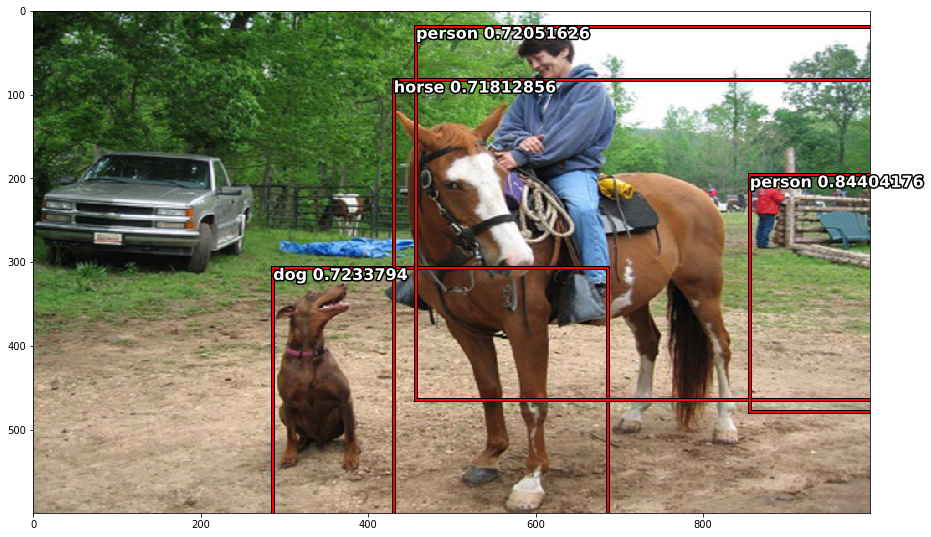

In [0]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).to(device)
trainer.load_model(f'/content/drive/My Drive/Colab Notebooks/FASTER_RCNN_weights/BEST_checkpoint_fasterrcnn.pt')
# !wget https://www.rd.com/wp-content/uploads/2019/11/cat-10-e1573844975155-768x519.jpg -O image.jpg
# image = Image.open("./VOCdevkit/VOC2007/JPEGImages/000005.jpg")
image = Image.open("demo.jpg")
with torch.no_grad():
    bboxes , labels,scores = trainer.faster_rcnn.predict(image,visualize=True)
    f, ax1 = plt.subplots(1, 1,figsize=(15,10))   
    ax1.imshow(resize(image))
    ax1.grid(False)

    for box ,label,score in zip(bboxes , labels,scores):
        box = torch.tensor([box[1],box[0],box[3],box[2]])
        draw_rect(ax1,box )
        draw_text(ax1, box[:2], trainLoader.dataset.class_names[label]+" "+str(score), sz=16)

### Evalulation calculating mAP

In [0]:
def calc_detection_voc_prec_rec(pred_bboxes,pred_labels, pred_scores,gt_bboxes,gt_labels, iou_thresh):
    """Calculate precision and recall based on evaluation code of PASCAL VOC.

    This function calculates precision and recall of
    predicted bounding boxes obtained from a dataset which has :math:`N`
    images.
    The code is based on the evaluation code used in PASCAL VOC Challenge.

    Returns:
        tuple of two lists:
        This function returns two lists: :obj:`prec` and :obj:`rec`.

        * :obj:`prec`: A list of arrays. :obj:`prec[l]` is precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, :obj:`prec[l]` is \
            set to :obj:`None`.
        * :obj:`rec`: A list of arrays. :obj:`rec[l]` is recall \
            for class :math:`l`. If class :math:`l` that is not marked as \
            difficult does not exist in \
            :obj:`gt_labels`, :obj:`rec[l]` is \
            set to :obj:`None`.

    """
    pred_bboxes = iter(pred_bboxes)
    pred_labels = iter(pred_labels)
    pred_scores = iter(pred_scores)
    gt_bboxes = iter(gt_bboxes)
    gt_labels = iter(gt_labels)
    
    n_pos = defaultdict(int)
    score = defaultdict(list)
    match = defaultdict(list)
    
    for pred_bbox , pred_label , pred_score,gt_bbox , gt_label in zip(pred_bboxes , pred_labels , pred_scores,gt_bboxes , gt_labels):
        
        for l in np.unique(np.concatenate((gt_label,pred_label))):
            pred_mask_l = pred_label == l
            pred_bbox_l = pred_bbox[pred_mask_l]
            pred_score_l = pred_score[pred_mask_l]
            
            #sort by score
            order = pred_score_l.argsort()[::-1]
            pred_bbox_l = pred_bbox_l[order]
            pred_score_l = pred_score_l[order]
            
            gt_mask_l = gt_label ==l
            gt_bbox_l = gt_bbox[gt_mask_l]
            
            n_pos[l] += gt_mask_l.sum()
            score[l].extend(pred_score_l)
            
            if len(pred_bbox_l) == 0:
                continue
            if len(gt_bbox_l) == 0:
                match[l].extend((0,) * pred_bbox_l.shape[0])
                continue
                
            pred_bbox[:,2:] += 1
            gt_bbox_l[:,2:] += 1
            iou = bbox_iou(pred_bbox_l , gt_bbox_l)
            gt_index = iou.argmax(axis=1)
            # set -1 if there is no matching ground truth
            gt_index[iou.max(axis=1) < iou_thresh]=-1
            del iou
            
            selec = np.zeros(gt_bbox_l.shape[0] , dtype=bool)
            
            for gt_idx in gt_index:
                if gt_idx >=0:
                    if not selec[gt_idx]:
                        match[l].append(1)
                    else:
                        match[l].append(0)
                    selec[gt_idx]=True
                else:
                    match[l].append(0)
                    
    n_fg_class = max(n_pos.keys())+1
    prec = [None] * n_fg_class
    rec = [None] *n_fg_class
    
    for l in n_pos.keys():
        score_l = np.array(score[l])
        match_l = np.array(match[l],dtype=np.int8)
        
        order = score_l.argsort()[::-1]
        match_l = match_l[order]
        
        tp = np.cumsum(match_l==1)
        fp = np.cumsum(match_l==0)
        # If an element of fp + tp is 0,
        # the corresponding element of prec[l] is nan.
        prec[l] = tp/(fp+tp)
        
        if n_pos[l] > 0:
            rec[l] = tp/n_pos[l]
            
    return prec,rec            

In [0]:
def calc_detection_voc_ap(prec, rec, use_07_metric=True):
    """Calculate average precisions based on evaluation code of PASCAL VOC.

    This function calculates average precisions
    from given precisions and recalls.
    The code is based on the evaluation code used in PASCAL VOC Challenge.

    Args:
        prec (list of numpy.array): A list of arrays.
            :obj:`prec[l]` indicates precision for class :math:`l`.
            If :obj:`prec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        rec (list of numpy.array): A list of arrays.
            :obj:`rec[l]` indicates recall for class :math:`l`.
            If :obj:`rec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.

    Returns:
        ~numpy.ndarray:
        This function returns an array of average precisions.
        The :math:`l`-th value corresponds to the average precision
        for class :math:`l`. If :obj:`prec[l]` or :obj:`rec[l]` is
        :obj:`None`, the corresponding value is set to :obj:`numpy.nan`.

    """

    n_fg_class = len(prec)
    ap = np.empty(n_fg_class)
    for l in six.moves.range(n_fg_class):
        if prec[l] is None or rec[l] is None:
            ap[l] = np.nan
            continue

        if use_07_metric:
            # 11 point metric
            ap[l] = 0
            for t in np.arange(0., 1.1, 0.1):
                if np.sum(rec[l] >= t) == 0:
                    p = 0
                else:
                    p = np.max(np.nan_to_num(prec[l])[rec[l] >= t])
                ap[l] += p / 11
        else:
            # correct AP calculation
            # first append sentinel values at the end
            mpre = np.concatenate(([0], np.nan_to_num(prec[l]), [0]))
            mrec = np.concatenate(([0], rec[l], [1]))

            mpre = np.maximum.accumulate(mpre[::-1])[::-1]

            # to calculate area under PR curve, look for points
            # where X axis (recall) changes value
            i = np.where(mrec[1:] != mrec[:-1])[0]

            # and sum (\Delta recall) * prec
            ap[l] = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

In [0]:

def eval_detection_voc(pred_bboxes,
                       pred_labels, 
                       pred_scores, 
                       gt_bboxes, gt_labels,
                       iou_thresh=0.5):
    """Calculate average precisions based on evaluation code of PASCAL VOC.

    This function evaluates predicted bounding boxes obtained from a dataset
    which has :math:`N` images by using average precision for each class.
    The code is based on the evaluation code used in PASCAL VOC Challenge.

    Args:
        pred_bboxes (iterable of numpy.ndarray): An iterable of :math:`N`
            sets of bounding boxes.
            Its index corresponds to an index for the base dataset.
            Each element of :obj:`pred_bboxes` is a set of coordinates
            of bounding boxes. This is an array whose shape is :math:`(R, 4)`,
            where :math:`R` corresponds
            to the number of bounding boxes, which may vary among boxes.
            The second axis corresponds to
            :math:`y_{min}, x_{min}, y_{max}, x_{max}` of a bounding box.
        pred_labels (iterable of numpy.ndarray): An iterable of labels.
            Similar to :obj:`pred_bboxes`, its index corresponds to an
            index for the base dataset. Its length is :math:`N`.
        pred_scores (iterable of numpy.ndarray): An iterable of confidence
            scores for predicted bounding boxes. Similar to :obj:`pred_bboxes`,
            its index corresponds to an index for the base dataset.
            Its length is :math:`N`.
        gt_bboxes (iterable of numpy.ndarray): An iterable of ground truth
            bounding boxes
            whose length is :math:`N`. An element of :obj:`gt_bboxes` is a
            bounding box whose shape is :math:`(R, 4)`. Note that the number of
            bounding boxes in each image does not need to be same as the number
            of corresponding predicted boxes.
        gt_labels (iterable of numpy.ndarray): An iterable of ground truth
            labels which are organized similarly to :obj:`gt_bboxes`.
        iou_thresh (float): A prediction is correct if its Intersection over
            Union with the ground truth is above this value.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.

    Returns:
        dict:

        The keys, value-types and the description of the values are listed
        below.

        * **ap** (*numpy.ndarray*): An array of average precisions. \
            The :math:`l`-th value corresponds to the average precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, the corresponding \
            value is set to :obj:`numpy.nan`.
        * **map** (*float*): The average of Average Precisions over classes.

    """

    prec, rec = calc_detection_voc_prec_rec(pred_bboxes,
                                            pred_labels, 
                                            pred_scores,
                                            gt_bboxes,
                                            gt_labels,
                                            iou_thresh=iou_thresh)

    ap = calc_detection_voc_ap(prec, rec)

    return {'ap': ap, 'map': np.nanmean(ap)}

In [0]:
# trainer = main(0)

@nograd
def evalulation(dataloader , faster_rcnn):
  
    pred_bbox , pred_labels , pred_scores = [] , [] ,[]
    gt_bboxes , gt_labels = [] , []
  
    for imgs , gt_bboxes_ ,  gt_labels_ in tqdm(dataloader):
        pred_bboxes_ , pred_labels_ , pred_scores_ = faster_rcnn.predict(imgs)
        gt_bboxes.append(tonumpy(gt_bboxes_).reshape(-1,4))
        gt_labels.append(tonumpy(gt_labels_).ravel())

        pred_bbox.append(pred_bboxes_)
        pred_labels.append(pred_labels_)
        pred_scores.append(pred_scores_)
  
    return eval_detection_voc(pred_bbox , pred_labels , pred_scores,gt_bboxes , gt_labels)

evalulation(valLoader , trainer.faster_rcnn)    

  0%|          | 0/2510 [00:00<?, ?it/s]


ValueError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
